In [1]:
import sys, os
from pathlib import Path
if "../src" not in sys.path:
    sys.path.append("../src")

from dietcoke import Vocabulary

Mapping author time ...
File read: ../data/author_time/wiki_author_time.json


In [2]:
# 把清朝分批產生的 sparse matrix stack起來
# from scipy import sparse
# from tqdm.auto import tqdm

# fps = sorted([fp for fp in Path('../data/chunked_freq').glob('*清*.npz')])
# mats = [sparse.load_npz(fp) for fp in tqdm(fps)]
# mat = sparse.hstack(mats)
# sparse.save_npz('chunked_freq_清.npz', mat)

In [3]:
# 合併清朝的 column names
# import json
# import re

# with open('../data/chunked_freq/text_slice_lookup.json', 'r', encoding='utf-8') as f:
#     text_slice_lookup = json.load(f)

# lst = [text_slice_lookup[k] for k in sorted(list(text_slice_lookup.keys())) if '清' in k]
# lst = [n for m in lst for n in m]

# # mat.shape[1] == len(lst)
# text_slice_lookup['chunked_freq_清'] = lst
# print(text_slice_lookup.keys())

# with open('text_slice_lookup.json', 'w', encoding='utf-8') as f:
#     json.dump(text_slice_lookup, f)

In [2]:
import json
from scipy import sparse
from tqdm.auto import tqdm
from dietcoke import dynaspan_lst, corpus_lst, Author
import numpy as np
import pandas as pd

In [3]:
# 抓出 dispersion 最高和最低的25個 characters
FOLDER = Path('../data/chunked_freq')

with open(FOLDER / 'text_slice_lookup.json', 'r', encoding='utf-8') as f:
    text_slice_lookup = json.load(f)

profile_df = pd.read_csv('../data/author_time/author_profile.csv').dropna(subset=['mid_year'])
midyear_lookup = dict(zip(profile_df['urn'], profile_df['mid_year']))

mat = None
cul_k, cul_k_lst = 0, []
for dynaspan in tqdm(dynaspan_lst):
    dyna_mat = sparse.load_npz(f'../data/chunked_freq/chunked_freq_{dynaspan}.npz')
    cols = [i for i, n in enumerate(text_slice_lookup[f'chunked_freq_{dynaspan}']) if n.split('_')[0] in midyear_lookup.keys()]
    
    dyna_mat = dyna_mat.todense()[:,cols]
    dyna_mat = sparse.csr_matrix(dyna_mat)
    print(dyna_mat.shape)
    cul_k += dyna_mat.shape[1]
    cul_k_lst.append(cul_k)

    if mat is None:
        mat = dyna_mat
    else:
        mat = sparse.hstack([mat, dyna_mat])

print(mat.shape)

  0%|          | 0/8 [00:00<?, ?it/s]

(54227, 12)


 25%|██▌       | 2/8 [00:02<00:06,  1.13s/it]

(54227, 675)


 38%|███▊      | 3/8 [00:05<00:09,  1.85s/it]

(54227, 1181)


 50%|█████     | 4/8 [00:11<00:13,  3.43s/it]

(54227, 2226)
(54227, 8443)


 62%|██████▎   | 5/8 [00:51<00:48, 16.17s/it]

(54227, 7489)


 75%|███████▌  | 6/8 [01:25<00:44, 22.19s/it]

(54227, 25778)


 88%|████████▊ | 7/8 [05:02<01:24, 84.67s/it]

(54227, 256)


100%|██████████| 8/8 [05:05<00:00, 38.13s/it]

(54227, 46060)


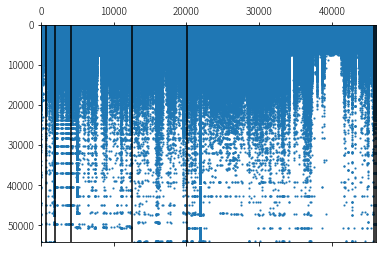

In [4]:
import matplotlib.pyplot as plt

plt.spy(mat, aspect='auto', markersize=1)
for cul_k in cul_k_lst:
    plt.axvline(x=cul_k, color="black")

In [5]:
cul_k_lst

[12, 687, 1868, 4094, 12537, 20026, 45804, 46060]

In [7]:
freq_mat = mat.sum(axis=1)
print(freq_mat.shape)

freq_df = pd.DataFrame(freq_mat, columns=['freq']) \
    .sort_values('freq', ascending=False) \
    .reset_index().rename({'index': 'char_id'}, axis=1)

vocab = Vocabulary('../data/dictionary.txt')
freq_df['char'] = [vocab.decode(char_id) for char_id in freq_df['char_id']]
freq_df = freq_df[['char_id', 'char', 'freq']]
freq_df = freq_df[freq_df['char'] != '〇']

target_chars = freq_df.iloc[1000:6000,]['char'].values
target_chars[:50]

(54227, 1)


array(['討', '庫', '荊', '聚', '避', '男', '戒', '旗', '藝', '巡', '麟', '班', '盤',
       '覺', '嵗', '湯', '隋', '階', '境', '辨', '委', '徵', '略', '族', '米', '屋',
       '熙', '溫', '軸', '慚', '惜', '獸', '徑', '駕', '祝', '靖', '提', '宇', '尹',
       '鑒', '絶', '歷', '敵', '并', '鳳', '蒼', '霜', '逆', '波', '助'],
      dtype=object)

In [8]:
indices = mat.nonzero()
data = np.ones(len(indices[0]))
binary_mat = sparse.csr_matrix((data, (indices[0], indices[1])), shape=mat.shape, dtype=int)

print(binary_mat.shape, mat.shape)
print(binary_mat.shape == mat.shape)

k_mat = binary_mat.sum(axis=1)
print(k_mat.shape)

(54227, 46060) (54227, 46060)
True
(54227, 1)


In [9]:
bi_df = pd.DataFrame(k_mat, columns=['d']).sort_values('d', ascending=False) \
        .reset_index().rename({'index': 'char_id'}, axis=1)
bi_df['char'] = [vocab.decode(char_id) for char_id in bi_df['char_id']]
bi_df = bi_df[bi_df['char'].isin(target_chars)].sort_values('d', ascending=False)
bi_df

,char_id,d,char
655,1013,33051,避
663,996,32884,聚
723,1054,31632,助
730,1064,31483,縱
744,1094,31120,殊
...,...,...,...
8939,5342,120,啊
9575,3668,86,捌
10501,6317,56,啥
11235,4194,42,㭍


In [10]:
overdispersed_chars = bi_df['char'].to_list()[:25]
underdispersed_chars = bi_df['char'].to_list()[-25:]

print('Overdispersed characters:', overdispersed_chars)
print('Underdispersed characters:', underdispersed_chars)

with open('overdispersed_chars.txt', 'w', encoding='utf-8') as f:
    f.write('\n'.join(overdispersed_chars))

with open('underdispersed_chars.txt', 'w', encoding='utf-8') as f:
    f.write('\n'.join(underdispersed_chars))

Overdispersed characters: ['避', '聚', '助', '縱', '殊', '假', '戒', '竟', '辨', '委', '屈', '負', '違', '仰', '庫', '畏', '屢', '惜', '逐', '符', '側', '覺', '貫', '稽', '稍']
Underdispersed characters: ['瑭', '尿', '酳', '皝', '嚐', '緞', '痘', '礼', '楽', '与', '鄩', '爹', '獘', '𣗳', '𧰼', '𫠦', '淂', '縀', '媽', '𡻕', '啊', '捌', '啥', '㭍', '叁']


In [11]:
# from scipy.sparse.linalg import svds, eigs
# from scipy import sparse

# mat = dyna_mat.astype(np.float64)
# u, s, vt = svds(mat, k=2)